In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [65]:
things = [["A1", "A2", "A3"], ["A4", "A5", "A6"], ["B1", "B2", "B3"], ["B4", "B5", "B6"], ["C1", "C2", "C3"], ["C4", "C5", "C6"], ["D1", "D2"], ["D3", "D4"], ["D5", "D6"]]
keys = [50, 75, 100, 150, 200, 250, "Untreated", "+ EtOH", "+ Fluorophore"]


In [66]:
def barplot_annotate_brackets(num1_list, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """
    num1 = num1_list[0]
    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .01

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'
        if len(text) > 2:
            text = "**"

    if isinstance(num2, (tuple, list, np.ndarray, pd.DataFrame)):
        rx = np.mean([center[num] for num in num2])
        ry = np.max(height[num1: num2[-1]])
    else:
        rx, ry = center[num2], np.max(height[num1:num2])
    lx, ly = center[num1], height[num1]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]


    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')
    for num1 in num1_list:
        lx = center[num1]
        plt.plot([lx, lx], [y, y+barh], c='black')
    if isinstance(num2, (tuple, list, np.ndarray, pd.DataFrame)):
        barx2 = [center[num2[0]], center[num2[-1]]]
        bary2 = [y, y]
        plt.plot(barx2, bary2, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

In [67]:
gene_file = pd.read_csv("glyco.csv")
gene_file.set_index(["X", "Y"], inplace=True)
gene_file = gene_file.dropna(axis=0, how="all")
controls = gene_file[["D1", "D2"]].to_numpy().flatten()
gene_file = gene_file / np.mean(controls[~np.isnan(controls)])

new_dict = {}
new_list = []
for key, thing in zip(keys, things):
    new_list.append(gene_file[thing].to_numpy().flatten())
for key, condition in zip(keys, new_list):
    new_dict[key] = pd.Series(condition).describe()
new_df = pd.DataFrame().from_dict(new_dict)
new_df = new_df.transpose()
new_df["sem"] = new_df["std"] / np.sqrt(new_df["count"])
full_df = pd.DataFrame().from_records(new_list)
full_df = full_df.transpose().rename(columns = {num : key for num, key in zip(np.arange(0, len(keys), 1), keys)})
new_df

,count,mean,std,min,25%,50%,75%,max,sem
50,63.0,1.104762,1.333856,0.0,0.0,1.2,1.8,4.8,0.168050
75,63.0,2.076190,1.144653,0.0,1.2,2.4,2.4,4.8,0.144213
100,63.0,3.638095,1.412779,1.2,2.4,3.6,4.8,7.2,0.177993
150,63.0,3.447619,1.337168,1.2,2.4,3.6,4.8,7.2,0.168467
200,57.0,3.978947,1.622029,1.2,2.4,3.6,4.8,8.4,0.214843
250,63.0,4.704762,1.794205,2.4,3.6,4.8,6.0,8.4,0.226049
Untreated,36.0,1.000000,1.014185,0.0,0.0,1.2,1.2,3.6,0.169031
+ EtOH,42.0,1.371429,1.011708,0.0,0.3,1.2,2.4,3.6,0.156110
+ Fluorophore,42.0,2.314286,1.167146,0.0,1.2,2.4,2.4,4.8,0.180095


In [68]:
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

stats_dict = {}
for cond in keys:
    cond_dict = {}
    for cond2 in keys:
        if cond == cond2:
            cond_dict[cond2] = np.NaN
        else:

            res = mannwhitneyu(full_df[cond], full_df[cond2], nan_policy="omit")
            cond_dict[cond2] = res.pvalue
    stats_dict[cond] = cond_dict
stats_df = pd.DataFrame().from_dict(stats_dict)
stats_df

,50,75,100,150,200,250,Untreated,+ EtOH,+ Fluorophore
50,NaN,7.659157e-06,6.425317e-15,4.580247e-14,7.199284e-15,3.242185e-18,9.379787e-01,8.478006e-02,3.191070e-06
75,7.659157e-06,NaN,3.079215e-09,6.278985e-08,7.557518e-10,8.426560e-15,1.798408e-05,2.980990e-03,3.139554e-01
100,6.425317e-15,3.079215e-09,NaN,5.465173e-01,2.102074e-01,9.160540e-04,2.922324e-13,9.046843e-13,3.635990e-06
150,4.580247e-14,6.278985e-08,5.465173e-01,NaN,6.371982e-02,1.169343e-04,1.621250e-12,1.119686e-11,3.895992e-05
200,7.199284e-15,7.557518e-10,2.102074e-01,6.371982e-02,NaN,5.321244e-02,9.550020e-13,2.619826e-12,6.835333e-07
250,3.242185e-18,8.426560e-15,9.160540e-04,1.169343e-04,5.321244e-02,NaN,3.145453e-15,8.225078e-16,8.522993e-11
Untreated,9.379787e-01,1.798408e-05,2.922324e-13,1.621250e-12,9.550020e-13,3.145453e-15,NaN,9.718968e-02,3.784809e-06
+ EtOH,8.478006e-02,2.980990e-03,9.046843e-13,1.119686e-11,2.619826e-12,8.225078e-16,9.718968e-02,NaN,3.328675e-04
+ Fluorophore,3.191070e-06,3.139554e-01,3.635990e-06,3.895992e-05,6.835333e-07,8.522993e-11,3.784809e-06,3.328675e-04,NaN


In [69]:
standard_df = full_df[["Untreated", "+ Fluorophore", "+ EtOH", 50, 75, 100, 150, 200, 250]]
standard_df


,Untreated,+ Fluorophore,+ EtOH,50,75,100,150,200,250
0,1.2,2.4,0.0,0.0,3.6,4.8,7.2,6.0,8.4
1,NaN,3.6,2.4,2.4,2.4,3.6,3.6,3.6,6.0
2,2.4,2.4,0.0,3.6,4.8,6.0,4.8,4.8,4.8
3,NaN,3.6,2.4,0.0,2.4,4.8,4.8,3.6,4.8
4,0.0,0.0,1.2,1.2,3.6,2.4,2.4,NaN,6.0
...,...,...,...,...,...,...,...,...,...
58,NaN,NaN,NaN,0.0,1.2,1.2,1.2,6.0,3.6
59,NaN,NaN,NaN,2.4,2.4,3.6,2.4,2.4,2.4
60,NaN,NaN,NaN,1.2,2.4,6.0,4.8,NaN,7.2
61,NaN,NaN,NaN,0.0,1.2,3.6,3.6,3.6,4.8


In [157]:
standard_df.describe()

,Untreated,+ Fluorophore,+ EtOH,50,75,100,150,200,250
count,36.000000,42.000000,42.000000,63.000000,63.000000,63.000000,63.000000,57.000000,63.000000
mean,1.000000,2.314286,1.371429,1.104762,2.076190,3.638095,3.447619,3.978947,4.704762
std,1.014185,1.167146,1.011708,1.333856,1.144653,1.412779,1.337168,1.622029,1.794205
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.200000,1.200000,1.200000,2.400000
25%,0.000000,1.200000,0.300000,0.000000,1.200000,2.400000,2.400000,2.400000,3.600000
50%,1.200000,2.400000,1.200000,1.200000,2.400000,3.600000,3.600000,3.600000,4.800000
75%,1.200000,2.400000,2.400000,1.800000,2.400000,4.800000,4.800000,4.800000,6.000000
max,3.600000,4.800000,3.600000,4.800000,4.800000,7.200000,7.200000,8.400000,8.400000


In [153]:
def boxplot(full_df):
    df_melt = pd.melt(full_df.reset_index(), id_vars=['index'], value_vars=full_df.columns)
    df_melt.columns= ["index", r"Analog Concentration ($\mu M$)", r"Normalized RFU"]
    ax = sns.boxplot(x=r"Analog Concentration ($\mu M$)", y=r"Normalized RFU", data=df_melt, palette=sns.dark_palette("#8BF", n_colors=8)[2:7])
    #ax = sns.violinplot(x=r"Polymer to DNA w/w Ratio", y=r"Normalized RFU", data=df_melt, palette=sns.dark_palette("#8BF", n_colors=8)[2:7])
def annotate(pairs, offsets, p_vals, data):
    count = 0
    for (i,  j) in pairs:
        significance = np.min(p_vals.iloc[i, j])
        print(significance)
        barplot_annotate_brackets(i, j, significance, np.arange(0, 9, 1), (data.max()).to_list())
        count += 1


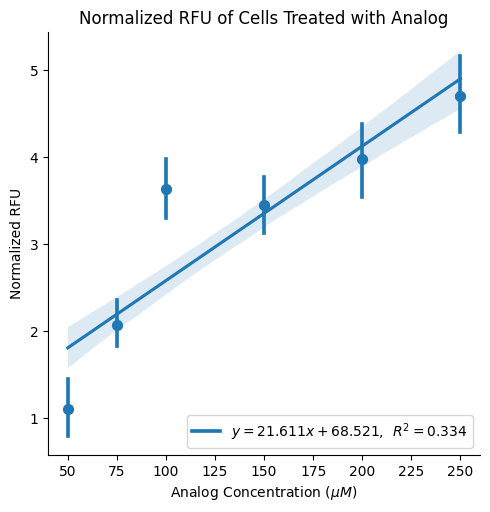

                            OLS Regression Results                            
Dep. Variable:               variable   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     185.7
Date:                Fri, 28 Apr 2023   Prob (F-statistic):           1.49e-34
Time:                        05:16:53   Log-Likelihood:                -2035.0
No. Observations:                 372   AIC:                             4074.
Df Residuals:                     370   BIC:                             4082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.5213      5.814     11.785      0.0

In [156]:
def lmplot(full_df):
    df_melt = pd.melt(full_df.reset_index(), id_vars=['index'], value_vars=full_df.columns)
    df_melt.columns= ["index", r"Analog Concentration ($\mu M$)", r"Normalized RFU"]
    df_melt = df_melt.astype('float64')
    df_melt.dropna()
    ax = sns.lmplot(x=r"Analog Concentration ($\mu M$)", y=r"Normalized RFU", data=df_melt, x_estimator=np.mean, palette=sns.dark_palette("#8BF", n_colors=1))
treated_df = standard_df[[50, 75, 100, 150, 200, 250]].astype('float64')
treated_df.rename(columns={ind: np.float64(ind) for ind in treated_df.columns}, inplace=True)

from sklearn.linear_model import LinearRegression

df_melt = pd.melt(treated_df.reset_index(), id_vars=['index'], value_vars=treated_df.columns)
df_melt = df_melt.astype('float64')
df_melt.dropna()

import statsmodels.formula.api as smf

model = smf.ols('variable ~ value', data=df_melt)
results = model.fit()

lmplot(treated_df)
plt.title("Normalized RFU of Cells Treated with Analog")
plt.legend([r'$y = {:.3f}x + {:.3f}$,  $ R^2 = {:.3f} $'.format(results.params["value"], results.params["Intercept"], results.rsquared)], loc="lower right")
plt.show()
print(results.summary())




In [140]:
results.params

Intercept    68.521318
value        21.611171
dtype: float64

6.425317439876452e-15
8.426560261264117e-15


<Figure size 640x480 with 0 Axes>

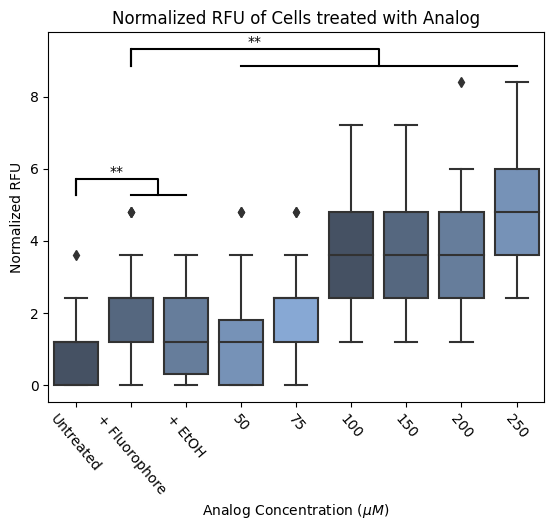

<Figure size 640x480 with 0 Axes>

In [154]:
pairs = [[[0], [1, 2]], [[1], [3, 4, 5, 6, 7, 8]]]
offsets = [0.1, 0.2, 0.3]


boxplot(standard_df)
plt.title("Normalized RFU of Cells treated with Analog")
plt.xticks(rotation=-50)
annotate(pairs, offsets, stats_df, standard_df)
plt.figure()
